# Fingerprint distances between structures for the same kinase

We investigate the ranges of fingerprint distances for each kinase pair:

- Compare the fingerprint distance distribution for intra-kinase pairs and inter-kinase pairs
- For the kinase pairs with highest structure pair coverage, show the range of fingerprint distances (consider minimum or median for structure-to-kinase mapping)
- Generate `kissim` kinase matrix for kinase subset investigated in the paper ["Analyzing Kinase Similarity in Small Molecule and Protein Structural Space to Explore the Limits of Multi-Target Screening"](https://www.mdpi.com/1420-3049/26/3/629)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from opencadd.databases.klifs import setup_remote

from kissim.comparison import FingerprintDistanceGenerator

In [3]:
HERE = Path(_dh[-1])  # noqa: F821
DATA = HERE / "../../results/all"

In [4]:
plt.style.use("seaborn")

In [5]:
%matplotlib inline

In [6]:
COVERAGE_CUTOFF = 0.8

## Load structural metadata

In [7]:
klifs_session = setup_remote()
structures = klifs_session.structures.all_structures()

## Load fingerprint distances

In [8]:
fingerprint_distance_file = DATA / "fingerprint_distances.csv.bz2"
fingerprint_distance_generator = FingerprintDistanceGenerator.from_csv(fingerprint_distance_file)
print(f"Number of kinases: {len(fingerprint_distance_generator.kinase_ids)}")
print(f"Number of structures: {len(fingerprint_distance_generator.structure_ids)}")
structure_distances = fingerprint_distance_generator.data
structure_distances.head()

Number of kinases: 279
Number of structures: 4681


,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage
0,1,4,EphA7,EphA7,0.011780,0.961333
1,1,8,EphA7,ITK,0.067187,0.946000
2,1,9,EphA7,ITK,0.095289,0.961333
3,1,11,EphA7,ITK,0.073468,0.961333
4,1,12,EphA7,ITK,0.067586,0.946000


### Add DFG conformation

In [9]:
def get_dfg(dfg, structure_klifs_id):
    try:
        return dfg[structure_klifs_id]
    except KeyError:
        return None

In [10]:
%%time
dfg = structures.set_index("structure.klifs_id")["structure.dfg"]
structure_distances["dfg.1"] = structure_distances["structure.1"].apply(
    lambda x: get_dfg(dfg, x)
)
structure_distances["dfg.2"] = structure_distances["structure.2"].apply(
    lambda x: get_dfg(dfg, x)
)

CPU times: user 55.8 s, sys: 369 ms, total: 56.1 s
Wall time: 56.1 s


### Filter distances by coverage cutoff

#### All conformation pairs

In [11]:
structure_distances["distance_filtered"] = np.where(
    structure_distances["bit_coverage"].values < COVERAGE_CUTOFF,
    np.nan,
    structure_distances["distance"].values,
)
structure_distances_filtered = structure_distances[
    structure_distances["distance_filtered"].notna()
]
print(f"Structure pairs: {structure_distances.shape[0]}")
print(f"Structure pairs not-NaN: {structure_distances_filtered.shape[0]}")

Structure pairs: 10953540
Structure pairs not-NaN: 10948918


#### DFG-in conformation pairs

In [12]:
%%time
# Select DFG-in only

# Without coverage cutoff
structure_distances_in_in = structure_distances[
    structure_distances.apply(lambda x: x["dfg.1"] == x["dfg.2"] == "in", axis=1)
]
# With coverage cutoff
structure_distances_filtered_in_in = structure_distances_filtered[
    structure_distances_filtered.apply(lambda x: x["dfg.1"] == x["dfg.2"] == "in", axis=1)
]

CPU times: user 2min 37s, sys: 2.82 s, total: 2min 40s
Wall time: 2min 40s


In [13]:
print(f"Structure pairs: {structure_distances_in_in.shape[0]}")
print(f"Structure pairs not-NaN: {structure_distances_filtered_in_in.shape[0]}")

Structure pairs: 8394753
Structure pairs not-NaN: 8392424


## Structure distances

### Structure distance distributions for different kinase subsets

- DFG-in pairs only!!!
- With cutoff!!!
- All structure distances
- Structure distances between the same kinases
- Structure distances between different kinases

In [14]:
structure_distances_filtered_in_in.describe().round(2)

,structure.1,structure.2,distance,bit_coverage,distance_filtered
count,8392424.00,8392424.00,8392424.00,8392424.00,8392424.00
mean,4088.29,8711.49,0.11,0.97,0.11
std,3002.41,3584.07,0.02,0.02,0.02
min,4.00,8.00,0.00,0.80,0.00
25%,1794.00,5596.00,0.10,0.96,0.10
50%,3416.00,9222.00,0.11,0.98,0.11
75%,5594.00,11943.00,0.12,0.99,0.12
max,13863.00,13864.00,0.24,1.00,0.24


In [15]:
structure_distances_filtered_in_in_df = pd.DataFrame(
    {
        "all": structure_distances_filtered_in_in["distance"],
        "intra-kinase": structure_distances_filtered_in_in[
            structure_distances_filtered_in_in["kinase.1"]
            == structure_distances_filtered_in_in["kinase.2"]
        ]["distance"],
        "inter-kinase": structure_distances_filtered_in_in[
            structure_distances_filtered_in_in["kinase.1"]
            != structure_distances_filtered_in_in["kinase.2"]
        ]["distance"],
    }
)

In [16]:
structure_distances_filtered_in_in_df.notna().sum()

all             8392424
intra-kinase     198444
inter-kinase    8193980
dtype: int64

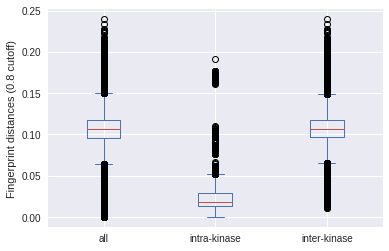

In [17]:
fig, axes = plt.subplots(1, 1)
structure_distances_filtered_in_in_df.plot(kind="box", ax=axes)
axes.set_ylabel(f"Fingerprint distances ({COVERAGE_CUTOFF} cutoff)")
fig.savefig(HERE / "../figures/kissim_discriminates_kinases.png", dpi=300)

### Per kinase distributions

How robust are structure distances within kinase pairs?

In [18]:
data = structure_distances_filtered_in_in[["kinase.1", "kinase.2", "distance"]].copy()
data[["kinase.1", "kinase.2"]] = np.sort(data[["kinase.1", "kinase.2"]], axis=1)

#### All kinase pairs

In [19]:
data_grouped_by_kinase_pairs = data.groupby(["kinase.1", "kinase.2"])

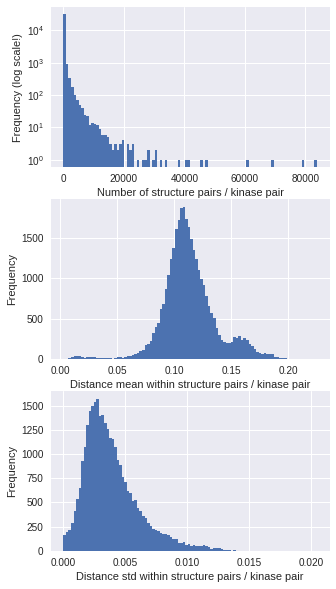

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(5, 10))
# Size
data_grouped_by_kinase_pairs.size().plot(
    ax=axes[0], kind="hist", logy=True, style=".", bins=100
)
axes[0].set_xlabel("Number of structure pairs / kinase pair")
axes[0].set_ylabel("Frequency (log scale!)")
# Mean
data_grouped_by_kinase_pairs.mean().squeeze().plot(
    ax=axes[1], kind="hist", style=".", bins=100
)
axes[1].set_xlabel("Distance mean within structure pairs / kinase pair")
# Std
data_grouped_by_kinase_pairs.std().squeeze().plot(
    ax=axes[2], kind="hist", logy=False, style=".", bins=100
)
axes[2].set_xlabel("Distance std within structure pairs / kinase pair");

In [21]:
for i in [1, 5, 10, 100, 1000, 10000, 100000]:
    size = data_grouped_by_kinase_pairs.size()
    n_structure_pairs_per_kinase_pair = size[size <= i].shape[0]
    info = f"Number of kinase pairs with <= {i} structure pairs"
    print(f"{info : <60}{n_structure_pairs_per_kinase_pair : >6}")
print(f"{'Number of kinase pairs' : <60}{size.shape[0]: 6}")

Number of kinase pairs with <= 1 structure pairs              1868
Number of kinase pairs with <= 5 structure pairs              7681
Number of kinase pairs with <= 10 structure pairs            11476
Number of kinase pairs with <= 100 structure pairs           24448
Number of kinase pairs with <= 1000 structure pairs          31251
Number of kinase pairs with <= 10000 structure pairs         32720
Number of kinase pairs with <= 100000 structure pairs        32816
Number of kinase pairs                                       32816


In [22]:
data_grouped_by_kinase_pairs.mean().describe()

,distance
count,32816.000000
mean,0.113385
std,0.023543
min,0.002720
25%,0.100357
50%,0.110804
75%,0.124129
max,0.225433


In [23]:
data_grouped_by_kinase_pairs.std().describe()

,distance
count,30948.000000
mean,0.003885
std,0.002242
min,0.000001
25%,0.002325
50%,0.003404
75%,0.004925
max,0.020475


#### Most frequent kinase pairs (DFG-in conformations only)

<AxesSubplot:>

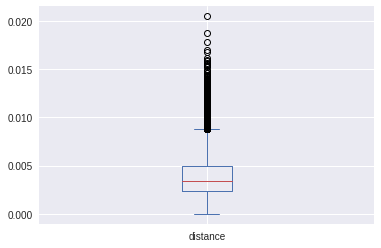

In [24]:
data_grouped_by_kinase_pairs["distance"].std().plot(kind="box")

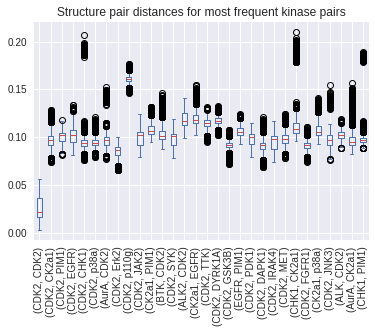

In [25]:
ntop = 30
index = data_grouped_by_kinase_pairs.size().sort_values(ascending=False).head(ntop).index
top_pair_distances = {
    pair: data_grouped_by_kinase_pairs.get_group(pair)["distance"] for pair in index
}
top_pair_distances = pd.DataFrame(top_pair_distances)
fig, axes = plt.subplots(1, 1)
top_pair_distances.plot(kind="box", ax=axes, rot=90)
axes.set_title("Structure pair distances for most frequent kinase pairs")
fig.savefig(
    HERE / f"../../notebooks/figures/figX_structure_distances_per_kinase_pair_top{ntop}.pdf",
    bbox_inches="tight",
)

#### Overall statistics

In [26]:
def n_pairs(n):
    return int((n ** 2 - n) / 2 + n)

In [27]:
structure_distances = structure_distances_in_in
structure_distances_filtered = structure_distances_filtered_in_in

n_structures = (
    pd.concat(
        [
            structure_distances["structure.1"],
            structure_distances["structure.2"]
        ]
    )
    .unique()
    .shape[0]
)
n_kinases = (
    pd.concat(
        [
            structure_distances["kinase.1"],
            structure_distances["kinase.2"]
        ]
    ).unique().shape[0]
)

In [28]:
n_structures_filtered = (
    pd.concat(
        [
            structure_distances_filtered["structure.1"],
            structure_distances_filtered["structure.2"]
        ]
    )
    .unique()
    .shape[0]
)
n_kinases_filtered = (
    pd.concat(
        [
            structure_distances_filtered["kinase.1"],
            structure_distances_filtered["kinase.2"]
        ]
    )
    .unique()
    .shape[0]
)

In [29]:
def get_n_kinase_pairs(structure_distances):
    return pd.DataFrame(
        np.sort(structure_distances[["kinase.1", "kinase.2"]], axis=1)
    ).drop_duplicates().shape[0]


n_kinase_pairs = get_n_kinase_pairs(structure_distances)
n_kinase_pairs_filtered = get_n_kinase_pairs(structure_distances_filtered)

In [30]:
table = {
    "All distances": [
        n_structures,
        n_pairs(n_structures),
        structure_distances.shape[0],
        n_kinases,
        n_pairs(n_kinases),
        n_kinase_pairs,
    ],
    "Only distances matching cutoff": [
        n_structures_filtered,
        n_pairs(n_structures_filtered),
        structure_distances_filtered.shape[0],
        n_kinases_filtered,
        n_pairs(n_kinases_filtered),
        n_kinase_pairs_filtered,
    ],
}
table = pd.DataFrame(
    table,
    index=[
        "Number of structures",
        "Number of structure pairs (theory)",
        "Number of structure pairs (experimental)",
        "Number of kinases",
        "Number of kinase pairs (theory)",
        "Number of kinase pairs (experimental)",
    ],
)
table

,All distances,Only distances matching cutoff
Number of structures,4098,4098
Number of structure pairs (theory),8398851,8398851
Number of structure pairs (experimental),8394753,8392424
Number of kinases,256,256
Number of kinase pairs (theory),32896,32896
Number of kinase pairs (experimental),32835,32816


## Dual kinases paper dataset

https://www.mdpi.com/1420-3049/26/3/629

In [32]:
KINASES_KLIFS_TO_PAPER = {
    "EGFR": "EGFR",
    "ErbB2": "ErbB2",
    "KDR": "VEGFR2",
    "p110a": "PI3K",
    "BRAF": "BRAF",
    "CDK2": "CDK2",
    "LCK": "LCK",
    "MET": "MET",
    "p38a": "p38a",
}

In [33]:
# All kinases
kinase_matrix = fingerprint_distance_generator.kinase_distance_matrix(
    coverage_min=COVERAGE_CUTOFF
)
# Select kinases from paper
example_kinase_matrix = kinase_matrix.loc[
    KINASES_KLIFS_TO_PAPER.keys(),
    KINASES_KLIFS_TO_PAPER.keys()
]
# Rename kinases to paper kinase names
example_kinase_matrix = example_kinase_matrix.rename(columns=KINASES_KLIFS_TO_PAPER)
example_kinase_matrix

kinase.2,EGFR,ErbB2,VEGFR2,PI3K,BRAF,CDK2,LCK,MET,p38a
kinase.1,,,,,,,,,
EGFR,0.000000,0.039648,0.068053,0.142969,0.092932,0.080826,0.075684,0.076089,0.091348
ErbB2,0.039648,0.000000,0.083884,0.161669,0.098179,0.088320,0.098872,0.086752,0.099634
KDR,0.068053,0.083884,0.000000,0.150364,0.085402,0.083035,0.078523,0.062961,0.083357
p110a,0.142969,0.161669,0.150364,0.000000,0.130396,0.143338,0.144332,0.152306,0.141210
BRAF,0.092932,0.098179,0.085402,0.130396,0.000000,0.078493,0.088816,0.091530,0.097344
CDK2,0.080826,0.088320,0.083035,0.143338,0.078493,0.000000,0.077310,0.077652,0.075778
LCK,0.075684,0.098872,0.078523,0.144332,0.088816,0.077310,0.000000,0.081988,0.093458
MET,0.076089,0.086752,0.062961,0.152306,0.091530,0.077652,0.081988,0.000000,0.099564
p38a,0.091348,0.099634,0.083357,0.141210,0.097344,0.075778,0.093458,0.099564,0.000000


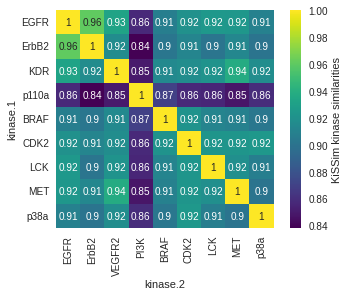

In [34]:
# Use similarities instead of distances
sns.heatmap(
    1 - example_kinase_matrix,
    linewidths=0,
    annot=True,
    square=True,
    cbar_kws={"label": "KiSSim kinase similarities"},
    cmap="viridis",
)
plt.show()

Compare to paper (shows similarities; not distances; __so think values inverse__):

![](https://www.mdpi.com/molecules/molecules-26-00629/article_deploy/html/images/molecules-26-00629-g002.png)

Figure 2. Heat maps of pairwise kinase similarities for the different measures used in this work: (A) ligand profile similarity (LigProfSim); (B) pocket sequence similarity (PocSeqSim); (C) interaction fingerprint similarity (IFPSim); (D) pocket structure similarity (PocStrucSim); and (E) docking rank similarity (DockRankSim) based on the lead-like subset of ZINC. Note that docking was only performed for the five kinases of Profiles 1–4, thus the remaining entries remain empty (white) in the matrix.